# **Case Study 2.1**: 
For this case study, your task is to apply the data cleaning techniques previously covered on a modified version of the Health Insurance Dataset obtained from Kaggle (https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset). You can access the dataset in the **ENCS5141_Exp2_HealthInsurance.csv** file. This file is available in the GitHub repository hosted at https://github.com/mkjubran/ENCS5141Datasets.


## 1. Data cleaning

In [ ]:
!rm -rf ../ENCS5141Datasets

In [ ]:
!git clone https://github.com/mkjubran/ENCS5141Datasets.git ../ENCS5141Datasets

In [1]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../ENCS5141Datasets/ENCS5141_Exp2_HealthInsurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [3]:
print(df.isnull().sum())
print("The size of the dataset", df.shape)

age         12
sex         19
bmi         17
children    52
smoker      17
region       0
charges      0
dtype: int64
The size of the dataset (1338, 7)


For category columns, we must check all possible labels and dublicates

In [6]:
print(df['sex'].unique())
print(df['smoker'].unique())
print(df['region'].unique())

['female' 'male' nan]
['yes' 'no' nan]
['southwest' 'southeast' 'northwest' 'northeast']


In [4]:
df.duplicated().value_counts()

False    1337
True        1
dtype: int64

In [5]:
df = df.drop_duplicates()

In [6]:
df

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


In [7]:
def corr_table(df):
    df_copy = df.copy()

    label_encoder = LabelEncoder()

    df_copy['sex_encoded'] = label_encoder.fit_transform(df_copy['sex'])
    df_copy['smoker_encoded'] = label_encoder.fit_transform(df_copy['smoker'])
    df_copy['region_encoded'] = label_encoder.fit_transform(df_copy['region'])

    df_copy.drop(['sex','smoker', 'region'],axis=1,inplace=True)

    return df_copy.corr()
corr_table(df)

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_encoded
age,1.000000,0.041382,0.046480,0.288812,0.010572,-0.025480,0.004271
bmi,0.041382,1.000000,-0.014459,0.095272,0.024730,-0.009239,0.093003
children,0.046480,-0.014459,1.000000,0.069920,0.006063,0.041615,0.035458
charges,0.288812,0.095272,0.069920,1.000000,0.084554,0.706272,-0.006547
sex_encoded,0.010572,0.024730,0.006063,0.084554,1.000000,0.077150,0.011150
smoker_encoded,-0.025480,-0.009239,0.041615,0.706272,0.077150,1.000000,-0.006643
region_encoded,0.004271,0.093003,0.035458,-0.006547,0.011150,-0.006643,1.000000


For the `smoker` column, there is a high correlation with the `charges` column. We plot the relation, we may set a threshold to separate the values or use the outcome distributions to detect the values.

<Axes: xlabel='charges', ylabel='Count'>

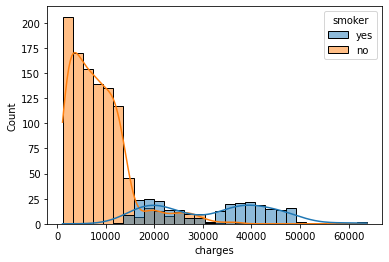

In [8]:
sns.histplot(data = df, x = 'charges', kde=True, hue = 'smoker')

In [9]:
threshold = 19000

df.loc[df['smoker'].isnull() & (df['charges'] > threshold), 'smoker'] = 'yes'
df.loc[df['smoker'].isnull() & (df['charges'] <= threshold), 'smoker'] = 'no'

In [10]:
print(df.isnull().sum())

age         12
sex         19
bmi         17
children    52
smoker       0
region       0
charges      0
dtype: int64


From the correlation table, `charges` can be used to determine the `age` column. First we will plot the relation between them.

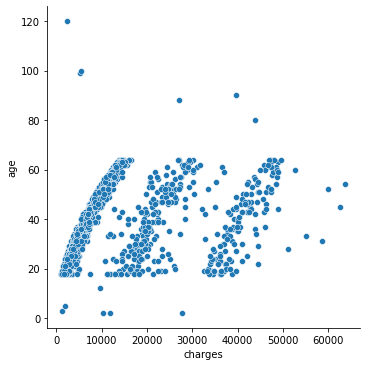

In [11]:
sns.relplot(data = df, x = 'charges', y = 'age')

I will use Kmeans clustering to define the threshold for each region as the med point between the means.

In [12]:
def draw_cluster(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    model = KMeans(n_clusters=3, random_state=42).fit(df[[x_col]])
    df['cluster'] = model.labels_

    iqr1 = df.groupby('cluster')[x_col].quantile(0.50)

    for cluster in df['cluster'].unique():
        df_cluster = df[(df['cluster'] == cluster) & (df[x_col] > iqr1[cluster])]
        sns.regplot(data=df_cluster, x=x_col, y=y_col, scatter=False, label=f'Cluster {cluster} Line')
        
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='cluster', palette='deep')

    plt.legend()
    plt.show()
    cetners = sorted(model.cluster_centers_.flatten())

    threshold1 = (cetners[0] + cetners[1]) / 2
    threshold2 = (cetners[1] + cetners[2]) / 2
    return threshold1, threshold2

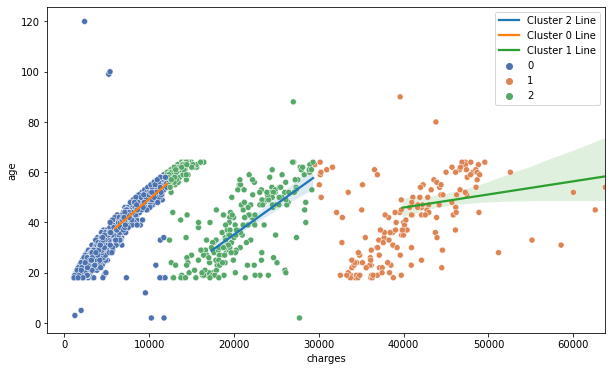

In [13]:
threshold1, threshold2 = draw_cluster(df, 'charges', 'age')

In [14]:
print(threshold1, threshold2)

12106.7470417177 29337.39748330826


In [15]:
from sklearn.linear_model import LinearRegression
def fill_nan(df_orig):
    df = df_orig.copy()
    df_missing = df[df['age'].isna()]
    
    if len(df_missing) == 0:
        return df
    
    df_not_missing = df[~df['age'].isna()]
    
    
    iqr1 = df_not_missing['charges'].quantile(0.25)
    
    train = df_not_missing[(df_not_missing['charges'] > iqr1)]
    
    model = LinearRegression()
    model.fit(train[['charges']], train['age'])

    x_missing = df_missing[['charges']]
    df.loc[df['age'].isna(), 'age'] = model.predict(x_missing)
    return df

In [16]:

df_s1 = df[df['charges'] <= threshold1]
df_s2 = df[(df['charges'] > threshold1) & (df['charges'] <= threshold2)]
df_s3 = df[df['charges'] > threshold2]

df_s1 = fill_nan(df_s1)
df_s2 = fill_nan(df_s2)
df_s3 = fill_nan(df_s3)

df = pd.concat([df_s1, df_s2, df_s3]).sort_index().reset_index(drop=True)


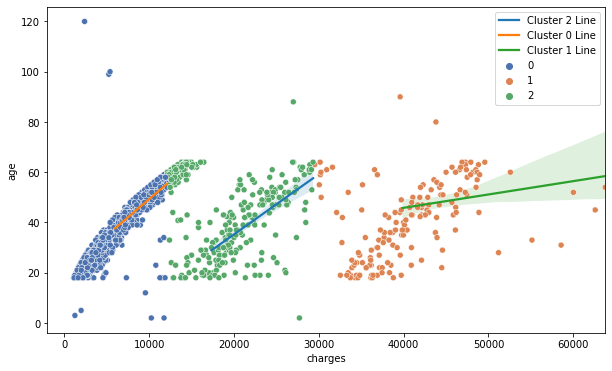

(12106.7470417177, 29337.39748330826)

In [17]:
draw_cluster(df, 'charges', 'age')

In [18]:
df = df.drop('cluster', axis=1)

In [19]:
print(df.isnull().sum())

age          0
sex         19
bmi         17
children    52
smoker       0
region       0
charges      0
dtype: int64


For `bmi`, we will replace it with the mean of the column and replace `sex` with the mode.

In [20]:
df.loc[df['bmi'].isna(), 'bmi']  = df['bmi'].mean()

In [21]:
print(df.isnull().sum())

age          0
sex         19
bmi          0
children    52
smoker       0
region       0
charges      0
dtype: int64


In [22]:
df.loc[df['sex'].isnull(), 'sex'] = df['sex'].mode().iloc[0]

In [23]:
print(df.isnull().sum())

age          0
sex          0
bmi          0
children    52
smoker       0
region       0
charges      0
dtype: int64


For `children`, I will use KNN to handle the missing data.
[KNNImputer](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)


In [24]:
df_copy = df.copy()

label_encoder = LabelEncoder()

df_copy['sex_encoded'] = label_encoder.fit_transform(df_copy['sex'])
df_copy['smoker_encoded'] = label_encoder.fit_transform(df_copy['smoker'])
df_copy['region_encoded'] = label_encoder.fit_transform(df_copy['region'])

df_copy.drop(['sex','smoker', 'region'],axis=1,inplace=True)

imputer = KNNImputer(n_neighbors=1)  
df_filled = imputer.fit_transform(df_copy)

df_imp = pd.DataFrame(df_filled, columns=df_copy.columns)

df['children'] = df_imp['children']


In [25]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [26]:
df

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50.0,male,30.970,3.0,no,northwest,10600.54830
1333,18.0,female,31.920,0.0,no,northeast,2205.98080
1334,18.0,female,36.850,0.0,no,southeast,1629.83350
1335,21.0,female,25.800,0.0,no,southwest,2007.94500


## Outliers
For `age` column, we will use the boxplot technique to detect outliers.

<Axes: >

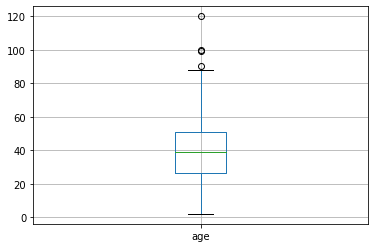

In [27]:
df.boxplot(column=['age'])

We will drop the outliers.

In [28]:
percentile_25 = df['age'].quantile(0.25)
percentile_50 = df['age'].quantile(0.5)
percentile_75 = df['age'].quantile(0.75)

print("25th Percentile:", percentile_25)
print("50th Percentile:", percentile_50)
print("75th Percentile:", percentile_75)

iqr = percentile_75 - percentile_25
print("Interquartile Range (IQR):", iqr)

LowerBound_age = percentile_25 - 1.5*iqr
UpperBound_age = percentile_75 + 1.5*iqr
print(f"Lower Bound = {LowerBound_age}, and Upper Bound = {UpperBound_age}")

25th Percentile: 26.252057417248544
50th Percentile: 39.0
75th Percentile: 51.0
Interquartile Range (IQR): 24.747942582751456
Lower Bound = -10.869856456878644, and Upper Bound = 88.12191387412719


In [29]:
NumRecordsBefore = df.shape[0]
df = df[(df['age'] >= LowerBound_age) & (df['age'] <= UpperBound_age)]
NumRecordsAfter = df.shape[0]
DroppedRecords = NumRecordsBefore - NumRecordsAfter
print(f"Number of detected outliers is {DroppedRecords} ({100*DroppedRecords/NumRecordsBefore}%)")

Number of detected outliers is 4 (0.2991772625280479%)


<Axes: >

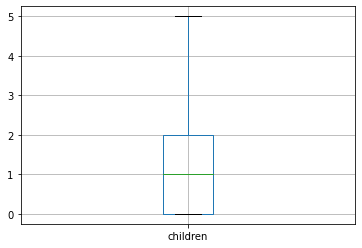

In [30]:
df.boxplot(column=['children'])

As shown above, box plot didn't detect any outlier. But we will study if there are relational outliers between age and children

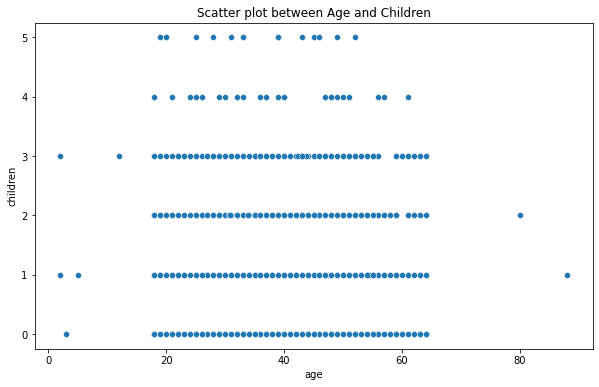

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='children')
plt.title("Scatter plot between Age and Children")
plt.show()

As we can see, there are very young people with children, which is impossible, so we will drop any row that age is less than 15 and have childrens

In [32]:
df = df[~((df['age'] < 16) & (df['children'] > 0))]

We will use Z-score fot `bmi`

In [33]:
mean = df['bmi'].mean()
std = df['bmi'].std()
print(f"For the height feature, the mean = {mean} and standard deviaton = {std} ")

LowerZScore_bmi = mean - 2.5*std
UpperZScore_bmi = mean + 2.5*std
print(f"Lower Z-Score = {LowerZScore_bmi}, and Upper Z-Score = {UpperZScore_bmi}")

For the height feature, the mean = 31.075203313253002 and standard deviaton = 10.746727722467337 
Lower Z-Score = 4.208384007084657, and Upper Z-Score = 57.94202261942135


In [34]:
NumRecordsBefore = df.shape[0]
df = df[(df['bmi'] >= LowerZScore_bmi) & (df['bmi'] <= UpperZScore_bmi)]
NumRecordsAfter = df.shape[0]
DroppedRecords = NumRecordsBefore - NumRecordsAfter
print(f"Number of detected outliers is {DroppedRecords} ({100*DroppedRecords/NumRecordsBefore}%)")

Number of detected outliers is 11 (0.8283132530120482%)


For charges, we will use Capping or Winsorizing the charges

In [35]:
lower = 5
upper = 90

min_charge = df['charges'].quantile(lower / 100)
max_charge = df['charges'].quantile(upper / 100)

df['charges_new'] = df['charges'].apply(lambda x: min_charge if x < min_charge else (max_charge if x > max_charge else x))


<Axes: >

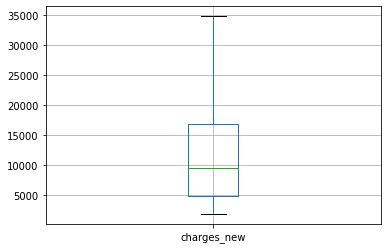

In [36]:
df.boxplot(column=['charges_new'])

In [37]:
df['charges'] = df['charges_new']
df = df.drop('charges_new', axis=1)

In [38]:
df.to_csv('Cleaned_dataset.csv')

In [39]:
import pandas as pd

def evaluate_data_handling(df):
    results = {}
    
    missing_data = df.isnull().sum()
    results['Missing Data Before'] = missing_data[missing_data > 0].to_dict()
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_data_before = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
    results['Outliers Before'] = outlier_data_before[outlier_data_before > 0].to_dict()
    

    
    return results

In [ ]:
before_cleaning = evaluate_data_handling(pd.read_csv("../ENCS5141Datasets/ENCS5141_Exp2_HealthInsurance.csv"))
after_cleaning  = evaluate_data_handling(df)

In [41]:
before_cleaning

{'Missing Data Before': {'age': 12,
  'sex': 19,
  'bmi': 17,
  'children': 52,
  'smoker': 17},
 'Outliers Before': {'age': 4, 'bmi': 18, 'charges': 139}}

In [42]:
after_cleaning

{'Missing Data Before': {}, 'Outliers Before': {'age': 1, 'bmi': 9}}